This notebooks produces the file `exp2_lung_tcells.h5` which is needed to produce some Figures in Fig4 and FigS4.

In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import os
import sys
import scvelo as scv
scv.settings.verbosity=1
from tqdm.notebook import tqdm

# Jupyter stuff
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
%matplotlib inline


In [2]:
# Lung tissue is in Exp2, pools 2 and 5.
DIR = '/fast/work/projects/bluethgen_landthaler/Cov19_Hamster/data/Impf/'  # replace with the DIR path you've set in the Snakefile
MDIR = '../metadata/'
libs = ['exp2_Pool2_nomulti', 'exp2_Pool5_nomulti']

# Load velocyto loomed h5 files
adatas = {}
for lib in libs:
    tdata = sc.read_10x_h5(f'{DIR}/{lib}/outs/raw_feature_bc_matrix.h5')
    tdata.var_names_make_unique()
    tdata.obs_names = [x.replace('-1', '') for x in tdata.obs_names]
    
    experiment, pool, _ = lib.split('_')
    tdata.obs['experiment'] = experiment
    tdata.obs['pool'] = pool
    tdata.obs['library'] = lib
    adatas[f'{experiment}_{pool}'] = tdata

# merge
adata = sc.concat(adatas, index_unique='-')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# load Seurat annotation
metadata_tcells = pd.read_csv(MDIR+'exp2_lung_Tcells_seurat_metadata.csv', index_col=0).drop([
    'integrated_snn_res.1', 'integrated_snn_res.0.5', 'integrated_snn_res.6', 'integrated_snn_res.0.6', 'integrated_snn_res.0.7'
], axis=1)
pca_tcells = pd.read_csv(MDIR+'exp2_lung_Tcells_seurat_pca.csv', index_col=0)

In [9]:
def rsum(X, axis):
    # handles sparse sum, returns array instead of matrix object
    return np.ravel(np.sum(X, axis=axis))

def calc_qc(adata, extended_genesets=False, species='detect', layer=None):
    adatas = adata if isinstance(adata, list) else [adata]
    for adata in adatas:
        X = adata.X if layer==None else adata.layers[layer]

        # qc counts
        adata.obs['ncounts'] = rsum(X, axis=1)
        adata.obs['ngenes'] = rsum(X>0, axis=1)
        adata.var['ncounts'] = rsum(X, axis=0)
        adata.var['ncells'] = rsum(X>0, axis=0)

In [10]:
# simplify / merge barcodes
Pool2=['aaUntr_1', 'aaUntr_2', 'adeno2x_1', 'adeno2x_2', 'adeno2x_3', 'att2x_1',  'att2x_2',  'att2x_3']
Pool5=['aaUntr_3', 'aaUntr_4', 'mRNA2x_1', 'mRNA2x_2', 'mRNA2x_3', 'mRNAatt_1', 'mRNAatt_2', 'mRNAatt_3']
stab2 = metadata_tcells[np.isin(metadata_tcells['orig.ident'], Pool2)]
stab2.index = [x.split('_')[-1][:-2]+'-exp2_Pool2' for x in stab2.index]
stab5 = metadata_tcells[np.isin(metadata_tcells['orig.ident'], Pool5)]
stab5.index = [x.split('_')[-1][:-2]+'-exp2_Pool5' for x in stab5.index]
metadata = pd.concat([stab2, stab5])
# cleanup
metadata = metadata.drop_duplicates()
detected = np.array([x in adata.obs_names for x in metadata.index])
cdata = adata[metadata.index[detected]]
cdata.obs = pd.concat([cdata.obs, metadata], axis=1)
cdata.obs_names_make_unique()
cdata.obs = cdata.obs.set_index('cell_id')
# add embeddings
cdata.obsm['X_umap_seurat'] = cdata.obs[['UMAP_1', 'UMAP_2']].values
cdata.obs=cdata.obs.drop(['UMAP_1', 'UMAP_2'], axis=1)
cdata.obsm['X_pca_seurat'] = pca_tcells.loc[cdata.obs_names].values
assert len(cdata) == len(pca_tcells)

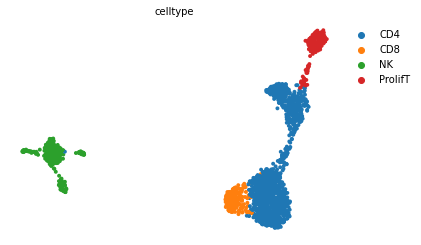

In [13]:
scv.pl.scatter(cdata, basis='umap_seurat', color='celltype')

In [14]:
# basic feature QC and preprocessing.
cdata.layers['counts'] = cdata.X
calc_qc(cdata)
sc.pp.normalize_per_cell(cdata)
sc.pp.filter_genes(cdata, min_cells=20)
sc.pp.log1p(cdata)
sc.pp.highly_variable_genes(cdata)
sc.pp.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.umap(cdata)

In [15]:
# Post hoc add spliced and unspliced layers
# load data
vdatas = {}
for lib in tqdm(libs):
    tdata = sc.read(f'{DIR}/{lib}/velocyto/{lib}_loom_velocyto.h5')
    tdata.var_names_make_unique()
    vdatas[lib] = tdata
vdata = sc.concat(vdatas, index_unique='_')

# identify cell barcodes
cdata.obs['veloc_bc'] = [f'{x.split("_")[-1]}_{lib}' for x, lib in zip(cdata.obs.index, cdata.obs.library)]

# align
genes = vdata.var.loc[cdata.var_names].index
cells = vdata.obs.loc[list(cdata.obs.veloc_bc)].index
subdata = vdata[cells, genes].copy()

# sanity check
assert(subdata.shape == cdata.shape)
assert(cdata.obs.veloc_bc[42] == subdata.obs_names[42])
assert(cdata.var_names[42] == subdata.var_names[42])

# add layers
for layer in ['spliced', 'unspliced']:
    cdata.layers[layer] = subdata.layers[layer].copy()

# drop immediate barcodes
cdata.obs = cdata.obs.drop('veloc_bc', axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
# overwrite old
cdata.write(DIR+'exp2_lung_tcells.h5')

... storing 'experiment' as categorical
